In [156]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random

# Load data

In [157]:
def load_pickle(filename):
    with open(filename, "rb") as f:
        data = pickle.load(f)
    return data

def load_ratings_and_factors():
    ratings = load_pickle('data/interaction_ratings')
    book_vectors = load_pickle('data/interaction_dict_book_factor')
    user_vectors = load_pickle('data/interaction_dict_reader_factor')
    return ratings, book_vectors, user_vectors

interactions_dict, book_vectors, user_vectors = load_ratings_and_factors()

Compute the 1000 x 200 user-book interaction matrix 'interactions', where interactions[i][j] == 1 if and only if user i has interacted with book j.

In [158]:
max_i = max(key[0] for key in interactions_dict.keys())
max_j = max(key[1] for key in interactions_dict.keys())
num_rows = max_i
num_cols = max_j

print(num_rows, 'users')
print(num_cols, 'books')

result_array = np.zeros((num_rows, num_cols), dtype=int)

for (i, j), value in interactions_dict.items():
    result_array[i-1, j-1] = value

# the 1000 x 200 matrix of user-book interactions
interactions = result_array

1000 users
200 books


Compute the normalized embeddings of each book. book_vectors_normalized[j] is the 10-dimensional normalized embedding for book j.

In [159]:
def normalize(v, phi=1):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / (norm ** phi)

book_vectors = np.array([v for v in book_vectors])
book_vectors_normalized = np.array([normalize(v) for v in book_vectors])

Compute a list of book interactions for each user. interactions_list[i] is a list of books that user i has interacted with.

In [160]:
interactions_list = [[] for _ in range(1000)]
for i in range(1000):
    if np.sum(interactions[i]) > 1:
        interactions_list[i] = list(np.squeeze(np.where(interactions[i]==1)))

Define a function to return a train and test set for a given user.

In [161]:
''' return a train set of book indices, and a single test book index'''
def get_train_test(user, train_size, test_size=1):
    assert np.sum(interactions[user]) >= train_size + test_size
    train_moods = list(random.sample(interactions_list[user], train_size + test_size))
    test_moods = train_moods[train_size:]
    train_moods = train_moods[:train_size]
    return train_moods, test_moods

train_moods, test_mood = get_train_test(1, 10)
print(train_moods, test_mood)

[91, 96, 90, 50, 55, 89, 92, 77, 86, 56] [68]


Define a function to return a train and test set selected from the set of all users

In [162]:
user_vectors = np.array([v for v in user_vectors])
user_vectors_normalized = np.array([normalize(v) for v in user_vectors])
users = [i for i in range(1000) if np.sum(interactions[i]) >= 20]

''' return a train set of book indices, and a single test book index'''
def get_train_test_coldstart(users, train_size, test_size=1):
    train_users = list(random.sample(users, train_size + test_size))
    test_user = train_users[train_size:]
    train_users = train_users[:train_size]
    return train_users, test_user

train_users, test_user = get_train_test_coldstart(users, 10)
print(train_users, test_user)

# i,j entry is the dot product between user i and book j
book_user_vector_dots = book_vectors_normalized @ user_vectors_normalized.T

[677, 865, 313, 314, 389, 134, 904, 544, 860, 867] [718]


Compute 200x200 matrix, where the i,j entry is the dot product between book i and book j. This is used to compute diversity.

In [163]:
book_vector_dots = book_vectors_normalized @ book_vectors_normalized.T

Define a function to evaluate a set of recommendations given a user's mood. Returns both accuracy (average value of recommendations), and utility (maximum value of recommendations)

In [164]:
def relu(x):
    return max(0, x)

# vector_dots is an m x n matrix where m is the number of items, and n is the number of user preferences
def evaluate(recommendations, test_mood, vector_dots):
    acc = 0
    utility = 0
    max_value = 0

    # values = vector_dots[recommendations][:,test_mood]
    # values[values < 0] = 0
    # acc = np.mean(values)
    for i in recommendations:
        acc += relu(vector_dots[i][test_mood])
        value = relu(vector_dots[i][test_mood])
        if value > max_value:
            max_value = value
    
    acc = acc / len(recommendations)
    # utility = np.max([0, np.max(vector_dots[recommendations][:,test_mood])])
    utility = max_value

    return acc, utility

Define a function to return a set of empirically accuracy-maximizing recommendations given a user's past interactions.

In [165]:
def update_sorted_list(pred_values, recommendations, lam):
    sim_to_recs = (1/len(recommendations)) * (1 - np.sum(book_vector_dots[:, recommendations], axis=1))
    total_values = (1 - lam) * np.array(pred_values) + lam * np.array(sim_to_recs)
    sorted_list = list(reversed(list(np.argsort(total_values))))
    return sorted_list


# vector_dots is an m x n matrix where m is the number of items, size is the number of user preferences, and lam is the weight on the diversity objective
def get_recommendations(train_moods, vector_dots, size, lam = 0):
    pred_values = []
    for i in range(200):
        pred_values.append(np.sum([relu(vector_dots[i][j]) for j in train_moods]))
    
    recommendations = []
    sorted_list = list(reversed(list(np.argsort(pred_values))))
    while len(recommendations) < size:
        new_item = False
        while new_item == False:
            i = sorted_list.pop(0)
            if i not in train_moods and i not in recommendations:
                new_item = True
                recommendations.append(i)
                sorted_list = update_sorted_list(pred_values, recommendations, lam)

    return recommendations

# Given past interactions [78, 90, 101, 88, 63], return a set of 5 accurate recommendations.
print('Accurate recommendations:', get_recommendations([78, 90, 101, 88, 63], book_vector_dots, 5, lam=0.1))

Accurate recommendations: [29, 138, 57, 47, 37]


Return a measure of diversity of a set of recommendations, equal to the average cosine distance between recommendations in the set.

In [166]:
def diversity(recommendations, book_vector_dots):
    score = 0
    num_recs = len(recommendations)
    # print(recommendations)
    # print(np.shape(book_vector_dots))
    for i in range(num_recs):
        for j in range(i, num_recs):
            score += 1 - book_vector_dots[recommendations[i]][recommendations[j]]
    return score / (num_recs * (num_recs - 1) / 2)

# Main Experiments (Unnormalized Item Embeddings)

Compare recommendations with varying levels of weight on diversity (lambda), according to accuracy, utility, and diversity.

## Individual-Level Recommendations

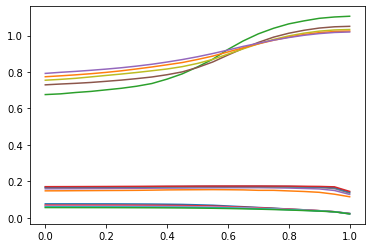

In [167]:
# unnormalized book vectors
vector_dots = book_vectors @ np.array([normalize(v) for v in book_vectors]).T
users = [i for i in range(1000) if np.sum(interactions[i]) >= 20]

accs_means_n = []
utils_means_n = []
divs_means_n = []
utilmax_lam_n = []

train_test_moods = [get_train_test(user, 10, 10) for user in users]

for n in [10, 20, 30, 40, 50]:
    accs_means = []
    utils_means = []
    divs_means = []

    lams = np.arange(0, 1.05, 0.05)
    for lam in lams:
        accs = []
        utils = []
        divs = []

        for train_moods, test_moods in train_test_moods:
            recs = get_recommendations(train_moods, vector_dots, n, lam=lam)
            divs.append(diversity(recs, book_vector_dots))

            for test_mood in test_moods:
                acc, utility = evaluate(recs, test_mood, vector_dots)
                accs.append(acc)
                utils.append(utility)

        accs_means.append(np.mean(accs))
        utils_means.append(np.mean(utils))
        divs_means.append(np.mean(divs))

    plt.plot(lams, accs_means)
    plt.plot(lams, utils_means)
    plt.plot(lams, divs_means)

    utilmax_lam_arg = np.argmax(utils_means)
    utilmax_lam_n.append(utilmax_lam_arg)

    accs_means_n.append(accs_means)
    utils_means_n.append(utils_means)
    divs_means_n.append(divs_means)

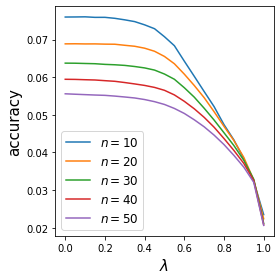

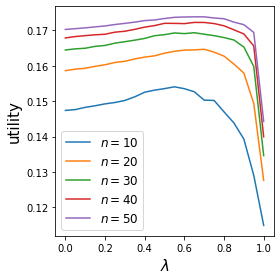

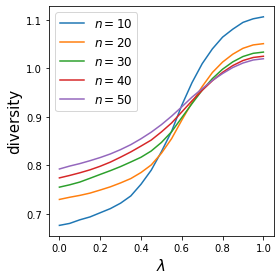

In [168]:
ns = [10, 20, 30, 40, 50]

plt.figure(figsize=(4,4))
for i, _ in enumerate(ns):
    plt.plot(lams, accs_means_n[i])
    plt.legend([r'$n=$'+str(n) for n in ns], fontsize=12)
    plt.xlabel(r'$\lambda$', fontsize=15)
    plt.ylabel('accuracy', fontsize=15)
plt.tight_layout()
plt.savefig('goodreads_individual_acc.png', dpi=300)
plt.show()

plt.figure(figsize=(4,4))
for i, _ in enumerate(ns): 
    plt.plot(lams, utils_means_n[i])
    plt.legend([r'$n=$'+str(n) for n in ns], fontsize=12)
    plt.xlabel(r'$\lambda$', fontsize=15)
    plt.ylabel('utility', fontsize=15)
plt.tight_layout()
plt.savefig('goodreads_individual_util.png', dpi=300)
plt.show()

plt.figure(figsize=(4,4))
for i, _ in enumerate(ns):  
    plt.plot(lams, divs_means_n[i])
    plt.legend([r'$n=$'+str(n) for n in ns], fontsize=12)
    plt.xlabel(r'$\lambda$', fontsize=15)
    plt.ylabel('diversity', fontsize=15)
plt.tight_layout()
plt.savefig('goodreads_individual_div.png', dpi=300)
plt.show()

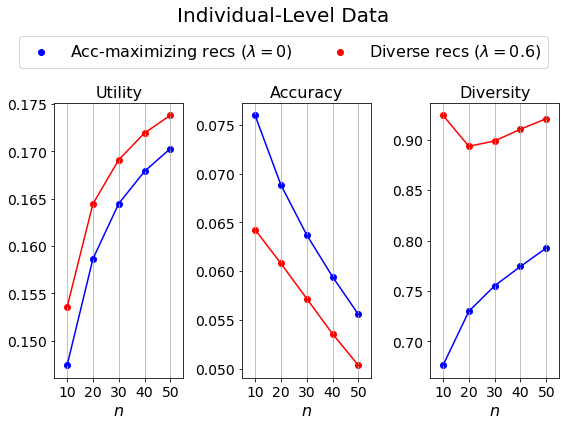

In [169]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8,6))

for ax in [ax1, ax2, ax3]:
    ax.grid(axis='x')
    ax.set_xticks(ns)
    ax.tick_params(labelsize=14)
    ax.set_xlim(5,55)
    ax.set_xlabel(r'$n$', fontsize=16)

accs_means_n_baseline = [accs_means_n[i][0] for i, _ in enumerate(ns)]
utils_means_n_baseline = [utils_means_n[i][0] for i, _ in enumerate(ns)]
divs_means_n_baseline = [divs_means_n[i][0] for i, _ in enumerate(ns)]
accs_means_n_utilmax = [accs_means_n[i][12] for i, _ in enumerate(ns)]
utils_means_n_utilmax = [utils_means_n[i][12] for i, _ in enumerate(ns)]
divs_means_n_utilmax = [divs_means_n[i][12] for i, _ in enumerate(ns)]

ax1.scatter(ns, utils_means_n_baseline, color='blue', alpha = 1)
ax1.plot(ns, utils_means_n_baseline, color='blue', alpha = 1)
ax1.scatter(ns, utils_means_n_utilmax, color='red', alpha = 1)
ax1.plot(ns, utils_means_n_utilmax, color='red', alpha = 1)
ax1.set_title('Utility', fontsize=16)

ax2.scatter(ns, accs_means_n_baseline, color='blue', alpha = 1, label=r'Acc-maximizing recs $(\lambda=0)$')
ax2.plot(ns, accs_means_n_baseline, color='blue', alpha = 1)
ax2.scatter(ns, accs_means_n_utilmax, color='red', alpha = 1, label=r'Diverse recs $(\lambda=0.6)$')
ax2.plot(ns, accs_means_n_utilmax, color='red', alpha = 1)
ax2.set_title('Accuracy', fontsize=16)

ax3.scatter(ns, divs_means_n_baseline, color='blue', alpha = 1)
ax3.plot(ns, divs_means_n_baseline, color='blue', alpha = 1)
ax3.scatter(ns, divs_means_n_utilmax, color='red', alpha = 1)
ax3.plot(ns, divs_means_n_utilmax, color='red', alpha = 1)
ax3.set_title('Diversity', fontsize=16)

fig.legend(fontsize=16, loc="lower center", ncol = 2, bbox_to_anchor=(0.5, 0.82))

fig.suptitle('Individual-Level Data\n\n', fontsize=20)
fig.tight_layout(pad=1.2)
plt.savefig('goodreads_individual.png', dpi=300)
plt.show()

## Population-Level Recommendations (Cold Start Setting)

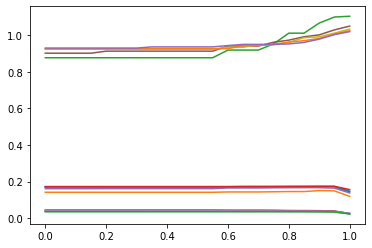

In [170]:
# unnormalized book vectors
users_all = [i for i in range(1000) if np.sum(interactions[i]) >= 1]
vector_dots = book_vectors @ user_vectors_normalized.T

accs_means_n = []
utils_means_n = []
divs_means_n = []
utilmax_lam_n = []

train_moods, test_moods = get_train_test_coldstart(users_all, 100, len(users_all)-100)

for n in [10, 20, 30, 40, 50]:
    accs_means = []
    utils_means = []
    divs_means = []

    lams = np.arange(0, 1.05, 0.05)
    for lam in lams:
        accs = []
        utils = []
        divs = []
        recs = get_recommendations(train_moods, vector_dots, n, lam=lam)

        divs.append(diversity(recs, book_vector_dots))

        for test_mood in test_moods:
            acc, utility = evaluate(recs, test_mood, vector_dots)
            accs.append(acc)
            utils.append(utility)

        accs_means.append(np.mean(accs))
        utils_means.append(np.mean(utils))
        divs_means.append(np.mean(divs))

    plt.plot(lams, accs_means)
    plt.plot(lams, utils_means)
    plt.plot(lams, divs_means)

    utilmax_lam_arg = np.argmax(utils_means)
    utilmax_lam_n.append(utilmax_lam_arg)

    accs_means_n.append(accs_means)
    utils_means_n.append(utils_means)
    divs_means_n.append(divs_means)

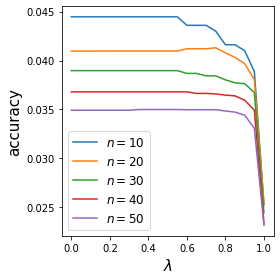

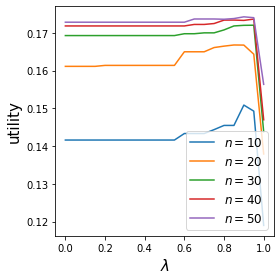

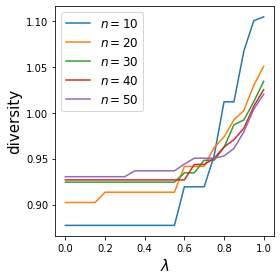

In [171]:
ns = [10, 20, 30, 40, 50]

plt.figure(figsize=(4,4))
for i, _ in enumerate(ns):
    plt.plot(lams, accs_means_n[i])
    plt.legend([r'$n=$'+str(n) for n in ns], fontsize=12)
    plt.xlabel(r'$\lambda$', fontsize=15)
    plt.ylabel('accuracy', fontsize=15)
plt.tight_layout()
plt.savefig('goodreads_population_acc.png', dpi=300)
plt.show()

plt.figure(figsize=(4,4))
for i, _ in enumerate(ns): 
    plt.plot(lams, utils_means_n[i])
    plt.legend([r'$n=$'+str(n) for n in ns], fontsize=12)
    plt.xlabel(r'$\lambda$', fontsize=15)
    plt.ylabel('utility', fontsize=15)
plt.tight_layout()
plt.savefig('goodreads_population_util.png', dpi=300)
plt.show()

plt.figure(figsize=(4,4))
for i, _ in enumerate(ns):  
    plt.plot(lams, divs_means_n[i])
    plt.legend([r'$n=$'+str(n) for n in ns], fontsize=12)
    plt.xlabel(r'$\lambda$', fontsize=15)
    plt.ylabel('diversity', fontsize=15)
plt.tight_layout()
plt.savefig('goodreads_population_div.png', dpi=300)
plt.show()

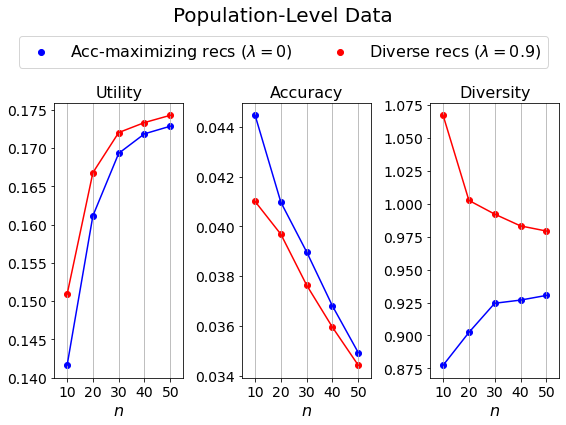

In [172]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8,6))

for ax in [ax1, ax2, ax3]:
    ax.grid(axis='x')
    ax.set_xticks(ns)
    ax.tick_params(labelsize=14)
    ax.set_xlim(5,55)
    ax.set_xlabel(r'$n$', fontsize=16)

accs_means_n_baseline = [accs_means_n[i][0] for i, _ in enumerate(ns)]
utils_means_n_baseline = [utils_means_n[i][0] for i, _ in enumerate(ns)]
divs_means_n_baseline = [divs_means_n[i][0] for i, _ in enumerate(ns)]
accs_means_n_utilmax = [accs_means_n[i][18] for i, _ in enumerate(ns)]
utils_means_n_utilmax = [utils_means_n[i][18] for i, _ in enumerate(ns)]
divs_means_n_utilmax = [divs_means_n[i][18] for i, _ in enumerate(ns)]

ax1.scatter(ns, utils_means_n_baseline, color='blue', alpha = 1)
ax1.plot(ns, utils_means_n_baseline, color='blue', alpha = 1)
ax1.scatter(ns, utils_means_n_utilmax, color='red', alpha = 1)
ax1.plot(ns, utils_means_n_utilmax, color='red', alpha = 1)
ax1.set_title('Utility', fontsize=16)

ax2.scatter(ns, accs_means_n_baseline, color='blue', alpha = 1, label=r'Acc-maximizing recs $(\lambda=0)$')
ax2.plot(ns, accs_means_n_baseline, color='blue', alpha = 1)
ax2.scatter(ns, accs_means_n_utilmax, color='red', alpha = 1, label=r'Diverse recs $(\lambda=0.9)$')
ax2.plot(ns, accs_means_n_utilmax, color='red', alpha = 1)
ax2.set_title('Accuracy', fontsize=16)

ax3.scatter(ns, divs_means_n_baseline, color='blue', alpha = 1)
ax3.plot(ns, divs_means_n_baseline, color='blue', alpha = 1)
ax3.scatter(ns, divs_means_n_utilmax, color='red', alpha = 1)
ax3.plot(ns, divs_means_n_utilmax, color='red', alpha = 1)
ax3.set_title('Diversity', fontsize=16)

fig.legend(fontsize=16, loc="lower center", ncol = 2, bbox_to_anchor=(0.5, 0.82))

fig.suptitle('Population-Level Data\n\n', fontsize=20)
fig.tight_layout(pad=1.2)
plt.savefig('goodreads_population.png', dpi=300)
plt.show()

# Additional Experiments (Normalized Item Embeddings)

## Individual-Level Data

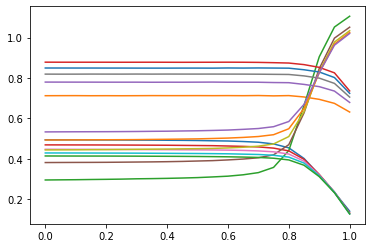

In [173]:
# normalized book vectors
vector_dots = np.array([normalize(v) for v in book_vectors]) @ np.array([normalize(v) for v in book_vectors]).T
users = [i for i in range(1000) if np.sum(interactions[i]) >= 20]

accs_means_n = []
utils_means_n = []
divs_means_n = []
utilmax_lam_n = []

train_test_moods = [get_train_test(user, 10, 10) for user in users]

for n in [10, 20, 30, 40, 50]:
    accs_means = []
    utils_means = []
    divs_means = []

    lams = np.arange(0, 1.05, 0.05)
    for lam in lams:
        accs = []
        utils = []
        divs = []

        for train_moods, test_moods in train_test_moods:
            recs = get_recommendations(train_moods, vector_dots, n, lam=lam)
            divs.append(diversity(recs, book_vector_dots))

            for test_mood in test_moods:
                acc, utility = evaluate(recs, test_mood, vector_dots)
                accs.append(acc)
                utils.append(utility)

        accs_means.append(np.mean(accs))
        utils_means.append(np.mean(utils))
        divs_means.append(np.mean(divs))

    plt.plot(lams, accs_means)
    plt.plot(lams, utils_means)
    plt.plot(lams, divs_means)

    utilmax_lam_arg = np.argmax(utils_means)
    utilmax_lam_n.append(utilmax_lam_arg)

    accs_means_n.append(accs_means)
    utils_means_n.append(utils_means)
    divs_means_n.append(divs_means)


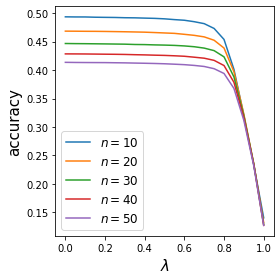

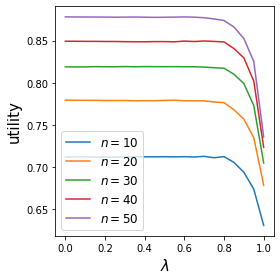

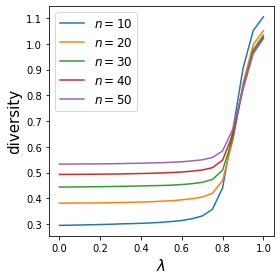

In [174]:
ns = [10, 20, 30, 40, 50]

plt.figure(figsize=(4,4))
for i, _ in enumerate(ns):
    plt.plot(lams, accs_means_n[i])
    plt.legend([r'$n=$'+str(n) for n in ns], fontsize=12)
    plt.xlabel(r'$\lambda$', fontsize=15)
    plt.ylabel('accuracy', fontsize=15)
plt.tight_layout()
plt.savefig('goodreads_individual_acc_normalized.png', dpi=300)
plt.show()

plt.figure(figsize=(4,4))
for i, _ in enumerate(ns): 
    plt.plot(lams, utils_means_n[i])
    plt.legend([r'$n=$'+str(n) for n in ns], fontsize=12)
    plt.xlabel(r'$\lambda$', fontsize=15)
    plt.ylabel('utility', fontsize=15)
plt.tight_layout()
plt.savefig('goodreads_individual_util_normalized.png', dpi=300)
plt.show()

plt.figure(figsize=(4,4))
for i, _ in enumerate(ns):  
    plt.plot(lams, divs_means_n[i])
    plt.legend([r'$n=$'+str(n) for n in ns], fontsize=12)
    plt.xlabel(r'$\lambda$', fontsize=15)
    plt.ylabel('diversity', fontsize=15)
plt.tight_layout()
plt.savefig('goodreads_individual_div_normalized.png', dpi=300)
plt.show()

## Population-Level Data (Cold Start Setting)

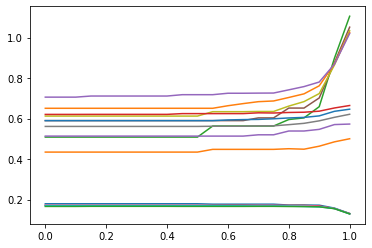

In [175]:
# normalized book vectors
users_all = [i for i in range(1000) if np.sum(interactions[i]) >= 1]
vector_dots = np.array([normalize(v) for v in book_vectors]) @ user_vectors_normalized.T

accs_means_n = []
utils_means_n = []
divs_means_n = []
utilmax_lam_n = []

train_moods, test_moods = get_train_test_coldstart(users_all, 100, len(users_all)-100)

for n in [10, 20, 30, 40, 50]:
    accs_means = []
    utils_means = []
    divs_means = []

    lams = np.arange(0, 1.05, 0.05)
    for lam in lams:
        accs = []
        utils = []
        divs = []
        recs = get_recommendations(train_moods, vector_dots, n, lam=lam)

        divs.append(diversity(recs, book_vector_dots))

        for test_mood in test_moods:
            acc, utility = evaluate(recs, test_mood, vector_dots)
            accs.append(acc)
            utils.append(utility)

        accs_means.append(np.mean(accs))
        utils_means.append(np.mean(utils))
        divs_means.append(np.mean(divs))

    plt.plot(lams, accs_means)
    plt.plot(lams, utils_means)
    plt.plot(lams, divs_means)

    utilmax_lam_arg = np.argmax(utils_means)
    utilmax_lam_n.append(utilmax_lam_arg)

    accs_means_n.append(accs_means)
    utils_means_n.append(utils_means)
    divs_means_n.append(divs_means)

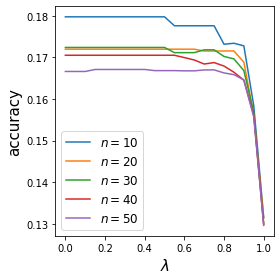

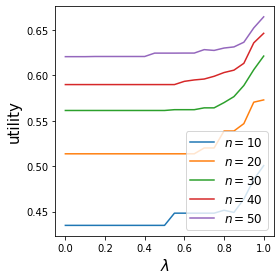

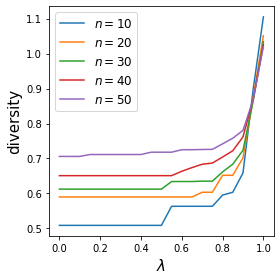

In [176]:
ns = [10, 20, 30, 40, 50]

plt.figure(figsize=(4,4))
for i, _ in enumerate(ns):
    plt.plot(lams, accs_means_n[i])
    plt.legend([r'$n=$'+str(n) for n in ns], fontsize=12)
    plt.xlabel(r'$\lambda$', fontsize=15)
    plt.ylabel('accuracy', fontsize=15)
plt.tight_layout()
plt.savefig('goodreads_population_acc_normalized.png', dpi=300)
plt.show()

plt.figure(figsize=(4,4))
for i, _ in enumerate(ns): 
    plt.plot(lams, utils_means_n[i])
    plt.legend([r'$n=$'+str(n) for n in ns], fontsize=12)
    plt.xlabel(r'$\lambda$', fontsize=15)
    plt.ylabel('utility', fontsize=15)
plt.tight_layout()
plt.savefig('goodreads_population_util_normalized.png', dpi=300)
plt.show()

plt.figure(figsize=(4,4))
for i, _ in enumerate(ns):  
    plt.plot(lams, divs_means_n[i])
    plt.legend([r'$n=$'+str(n) for n in ns], fontsize=12)
    plt.xlabel(r'$\lambda$', fontsize=15)
    plt.ylabel('diversity', fontsize=15)
plt.tight_layout()
plt.savefig('goodreads_population_div_normalized.png', dpi=300)
plt.show()